# 1. Load the data

Firstly we load the data from the downloaded repository. We load the data for the season 2023-24 as that is going to be our model season. Data for the season 2024-25 was not complete at the time of writing of this thesis so I cannot yet use it. I use Python's data manipulation library Pandas (pd) for transformations and working with tables and features throughout the entire notebook. 

The data contains several different statistics/metrics per each player per each game week. Some of the metrics are predictive in nature (e.g., expected goals) and some are the real values attained by a player in the particular game week (e.g., total points, goals).

In [1]:
# data load

import pandas as pd

# season = "2023-24"
df = pd.read_csv("data/merged_gw.csv")

pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None

df.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,starts,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Femi Seriki,DEF,Sheffield Utd,0.5,0,0,0,0,0.0,653,0.00,0.00,0.00,0.00,7,0,0,0.0,0.0,2023-08-12T14:00:00Z,0,8,0,0,0,0,1,0,0,0,1,0,0.0,0,0,0,0,40,True,0,1
1,Jack Hinshelwood,MID,Brighton,1.5,0,0,0,0,0.0,621,0.00,0.00,0.00,0.00,4,0,0,0.0,0.0,2023-08-12T14:00:00Z,0,12,0,0,0,0,1,0,822,0,1,4,0.0,0,0,0,0,45,True,0,1
2,Jadon Sancho,MID,Man Utd,3.0,0,0,4,0,11.3,397,0.05,0.05,0.00,1.08,10,0,0,2.3,3.8,2023-08-14T19:00:00Z,22,20,0,0,0,0,1,0,83993,0,0,1,8.0,1,0,0,0,70,True,0,1
3,Rhys Norrington-Davies,DEF,Sheffield Utd,0.1,0,0,0,0,0.0,487,0.00,0.00,0.00,0.00,7,0,0,0.0,0.0,2023-08-12T14:00:00Z,0,8,0,0,0,0,1,0,6456,0,1,0,0.0,0,0,0,0,40,True,0,1
4,Vitaly Janelt,MID,Brentford,2.1,0,0,6,0,11.5,105,0.01,0.03,0.02,1.26,8,2,0,4.3,14.6,2023-08-13T13:00:00Z,90,18,0,0,0,0,1,0,6508,1,2,2,17.0,2,0,0,0,55,True,0,1


# 2. Data preprocessing

Before the model creation we need to correct 2 undesirable characteristics of the data. 

1. There are some double game weeks throughout the season meaning that some players are going to have duplicated entries for some game weeks which is not desirable because the algorithm would treat these entries as separate players.

2. There are missing data for GW26 which is completely without expected points data - an important metric for our model. Luckily this metric shows a significant linear trend over time so a simple linear interpolation is not going to be far from the actual values.

In [2]:
# preprocessing - handling the double game weeks

import pandas as pd

# Aggregation rules
agg_rules = {
    "position": "first",
    "team": "first",
    "xP": "first",
    "assists": "sum",
    "bonus": "sum",
    "bps": "sum",
    "clean_sheets": "sum",
    "creativity": "sum",
    "element": "first",
    "expected_assists": "sum",
    "expected_goal_involvements": "sum",
    "expected_goals": "sum",
    "expected_goals_conceded": "sum",
    "fixture": lambda x: "NA",
    "goals_conceded": "sum",
    "goals_scored": "sum",
    "ict_index": "sum",
    "influence": "sum",
    "kickoff_time": lambda x: "NA",
    "minutes": "sum",
    "opponent_team": lambda x: "NA",
    "own_goals": "sum",
    "penalties_missed": "sum",
    "penalties_saved": "sum",
    "red_cards": "sum",
    "round": "first",
    "saves": "sum",
    "starts": lambda x: "NA",
    "selected": "first",
    "team_a_score": lambda x: "NA",
    "team_h_score": lambda x: "NA",
    "threat": "sum",
    "total_points": "sum",
    "transfers_balance": "first",
    "transfers_in": "first",
    "transfers_out": "first",
    "value": "first",
    "was_home": lambda x: "NA",
    "yellow_cards": "sum",
}

# Aggregate by player and game week
df_agg = df.groupby(["name", "GW"]).agg(agg_rules).reset_index()

# Identify groups with more than one row & filter the aggregated DataFrame to include only these groups
group_counts = df.groupby(["name", "GW"]).size()
duplicate_groups = group_counts[group_counts > 1].index
df_grouped_rows = df_agg[df_agg.set_index(["name", "GW"]).index.isin(duplicate_groups)]

# Reset the index for clean output, set aggregation flag for aggregated entries
df_grouped_rows.reset_index(drop=True, inplace=True)
df_grouped_rows.loc[:, "aggregation"] = "aggregate"
df.loc[:, 'aggregation'] = 'NA'

# set the entries that will be aggregated to double_week so that we can tell them apart
df.loc[df.duplicated(subset=["name", "GW"], keep=False), "aggregation"] = "double_week"
# concatenate the original df with the aggregated
df = pd.concat([df, df_grouped_rows], ignore_index=True)

# pre-processing -linear interpolation of GW 26

# specifically set the empty GW to NA data type
df.loc[(df["GW"] == 26), "xP"] = pd.NA
df_no_double_weeks = df[df["aggregation"] != "double_week"]

# interpolate the xP metric 
inter = (
    df_no_double_weeks[["name", "GW", "xP"]]
    .groupby(["name", "GW"])
    .apply(lambda x: x)
    .interpolate(method="linear")["xP"]
)

df_no_double_weeks.sort_values(["name", "GW"], inplace=True)
df_no_double_weeks.reset_index(inplace=True, drop=True)

# Append the new extrapolated metric to the old df
df_no_double_weeks["xP_inter"] = inter.reset_index()["xP"]

df_double_weeks = df[df["aggregation"] == "double_week"]
# double week players will have empty xP since we interpolate only the aggregates
df_double_weeks["xP_inter"] = pd.NA
df = pd.concat([df_no_double_weeks, df_double_weeks])
df.reset_index(drop=True, inplace=True)

# 3. Feature engineering

I drop the double game week entries and continue working only with the single entries plus the aggregates of the doubles. I create several different features (derived metrics) from the original ones in hope to extract more information and hopefully create some metrics that would correlate well with the ultimate points predicting metric.

I also join some other datasets on the original one to derive more information about matches such as whom the team has played and how was the difficulty of that game evaluated.

Some groups of the features I create:

1. Rolling points - Measures of cumulative expected points, cumulative total points assuming that the past performance is a good predictor of the current one. I also create rolling totals of points per 5 game weeks in an attempt to create some measure of player's recent form.

2. 

In [3]:
# Feature engineering

df_wo_doubles = df[df["aggregation"] != "double_week"]
# Rolling points
df_wo_doubles["rolling_xP"] = df.groupby("name")["xP"].transform(
    lambda x: x.rolling(38, min_periods=1).sum()
)
df_wo_doubles["rolling_total_points"] = df.groupby("name")["total_points"].transform(
    lambda x: x.rolling(38, min_periods=1).sum()
)

df_wo_doubles["rolling_xP_5gw"] = df.groupby("name")["xP"].transform(
    lambda x: x.rolling(5, min_periods=1).sum()
)
df_wo_doubles["rolling_total_points_5gw"] = df.groupby("name")[
    "total_points"
].transform(lambda x: x.rolling(5, min_periods=1).sum())

df_wo_doubles["rolling_xP_3gw"] = df.groupby("name")["xP"].transform(
    lambda x: x.rolling(3, min_periods=1).sum()
)
df_wo_doubles["rolling_total_points_3gw"] = df.groupby("name")[
    "total_points"
].transform(lambda x: x.rolling(3, min_periods=1).sum())


# Variance
df_wo_doubles["std_prev_gws"] = df_wo_doubles.groupby("name")["total_points"].transform(
    lambda x: x.shift().expanding().std()
)  # Shift to exclude the current GW

df_wo_doubles["xP_cv"] = (
    df_wo_doubles["std_prev_gws"] / df_wo_doubles["rolling_total_points"]
)  # Coefficient of Variation


# Totals
df_wo_doubles["season_goals"] = df_wo_doubles.groupby("name")["goals_scored"].transform(
    "cumsum"
)
df_wo_doubles["season_assists"] = df_wo_doubles.groupby("name")["assists"].transform(
    "cumsum"
)
df_wo_doubles["season_minutes"] = df_wo_doubles.groupby("name")["minutes"].transform(
    "cumsum"
)

# value
# Lag total points by 1 week for each player
df_wo_doubles["total_points_l1"] = df_wo_doubles.groupby("name")["total_points"].shift(
    -1
)

# Calculate points per million (ppm) using lagged total points
df_wo_doubles["ppm"] = (df_wo_doubles["total_points_l1"] / df_wo_doubles["value"]) * 10

# fixture difficulty
df_teams = pd.read_csv("data/teams.csv")
df_fixtures = pd.read_csv("data/fixtures.csv")

fixtures_subset = df_fixtures[["id", "team_a_difficulty", "team_h_difficulty"]]
# Merge the datasets
merged_df = df_wo_doubles.merge(
    fixtures_subset,
    left_on="fixture",
    right_on="id",
    how="left",
)

merged_df["fix_difficulty"] = merged_df["team_h_difficulty"]

for i in range(len(merged_df)):
    if merged_df["was_home"][i]:
        merged_df["fix_difficulty"][i] = merged_df["team_a_difficulty"][i]

# lagged influence/other measures
merged_df["influence_l1"] = merged_df.groupby("name")["influence"].shift(-1)
# I will need to find out how to work with aggregates when creating these features because
# they leave NaNs which LP has problems with

# filling the NaNs resulting from the aggregates not having the corresponding columns
merged_df["influence_l1"] = merged_df["influence_l1"].fillna(0)
merged_df["fix_difficulty"] = merged_df["fix_difficulty"].fillna(0)

merged_df['was_double_gw'] = merged_df['aggregation'].apply(lambda x: 0 if x == 'NA' else 1)

In [6]:
# Save the dataset

merged_df.to_pickle("data/final_data.pkl")

In [ ]:
# try scaling?
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Standardize the selected columns
columns_to_scale = ["total_points", "value", "expected_goals", "expected_assists"]
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# 4. Feature selection

Using a correlation matrix and my own "expert judgement" I selected several metrics best suited for the prediction of the best squad that I will include in the optimization models.

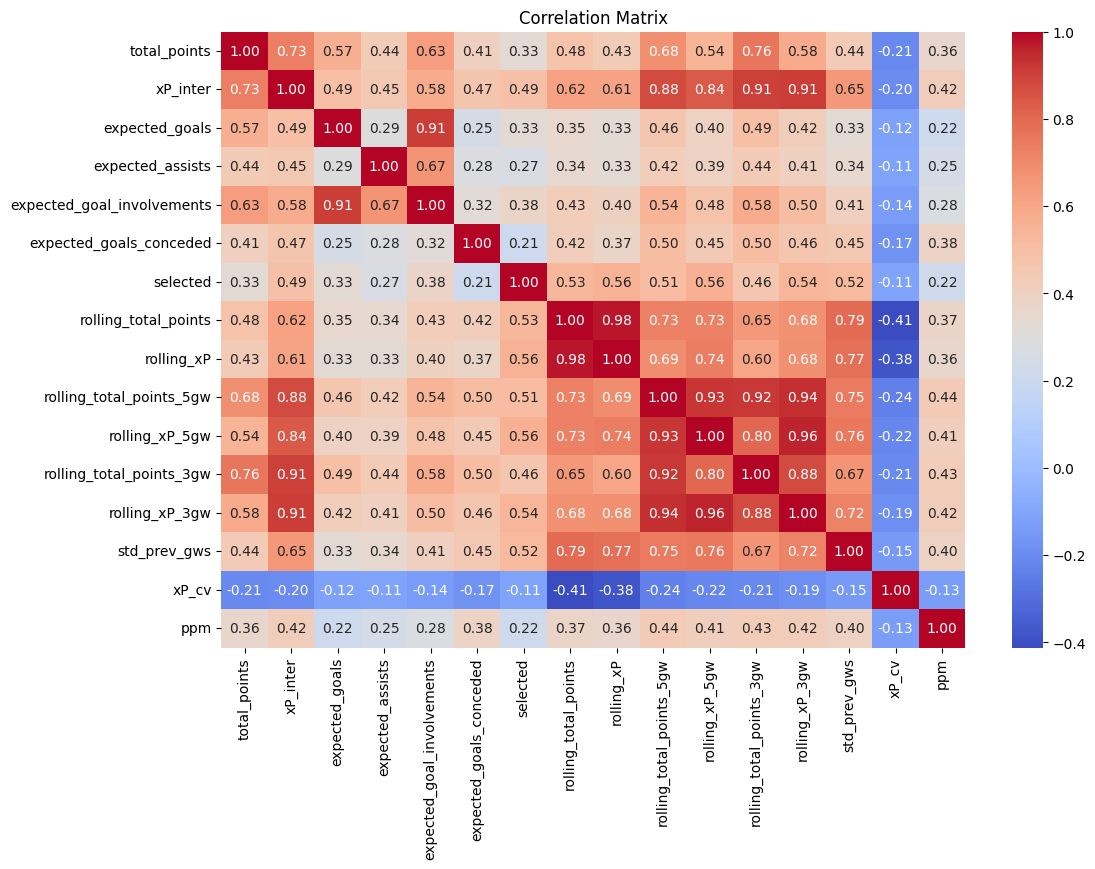

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
correlation_matrix = merged_df[
    [
        "total_points",
        "xP_inter",
        "expected_goals",
        "expected_assists",
        "expected_goal_involvements",
        "expected_goals_conceded",
        "selected",
        "rolling_total_points",
        "rolling_xP",
        "rolling_total_points_5gw",
        "rolling_xP_5gw",
        "rolling_total_points_3gw",
        "rolling_xP_3gw",
        "std_prev_gws",
        "xP_cv",
        # "season_goals",
        # "season_minutes",
        "ppm",
        #'influence_l1'
    ]
].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()